In [112]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import distributions
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('poster')

# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.curdir, './utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import sinvchi2
import plot_tools

# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

# Introduction

In inference problems, the model generally has multiple parameters. Nevertheless, we are interested, in most cases, in only a handful of them. Therefore the ultimate goal is to compute the marginal posterior distribution of the particular parameters of interest. The are two main approach to compute this marginal distribution:

1. Analytically: Derive the joint posterior distribution of **all** unknowns and then integrate out the unknowns that are not of immediate interest to obtain the desired marginal.
2. Numerically: Using simulation, we draw samples from the joint posterior and then look at the parameters of interest and ignore the values of other unknowns.

Parameters that are not of immediate interest are called **nuisance parameters**. In this notebook we follow closely the BDA book by introducing:

1. How to deal with nuisance parameters
2. Normal data with noninformative prior distribution
3. Normal data with conjugate prior distribution
4. Multinomial model for categorical data
5. Multivariate normal model with unknown variance
6. Muttivariate normal with unknown mean and variance.
7. Case study: bioassay

# Averaging over "nuisance parameters"

Suppose we have two subset of parameters $\theta_1$ and $\theta_2$ and we are interested in $\theta_1$ only. For example, in a nornaml model, we are generally intersted in the location parameter (the mean). So given data $y$, we take a look at the joint posterior distribution $p(\theta_1, \theta_2 | y)$. We can rewrite it as follows:

$$\begin{align}p(\theta_1, \theta_2 | y) = p(\theta_1 | \theta_2, y) p(\theta_2 |y)\\\end{align}$$

Now we integrate out the nuisance parameters $\theta_2$ to obtain the marginal posterior distribution of $\theta_1$:

$$p(\theta_1 |y) = \int p(\theta_1, \theta_2 | y)d\theta_2 = \int p(\theta_1 | \theta_2, y) p(\theta_2 |y)d\theta_2$$


We can view that the marginal posterior distribution of $\theta_2$ is obtained by **averaging** over possible values of $\theta_2$. Another view is the marginal posterior distribution is mixtured of conditional posterior distribution given $\theta_2$, weighted by the posterior distribution of $\theta_2$.

We rarely evaluate the integration on the RHS explicitly but rather using simulation. In other words, the posterior distribution of $\theta_1$ will be computed by first drawing $\theta_2$ from its posterior distribution and then draw $\theta_1$ from its conditional posterior distribution given $\theta_2$. This allows the integration to be computed indirectly. Let's see how this wok in the the problem of estimaing parameters for a normal model with unknown variance and mean. 

# Normal data with a noninformative prior distribution

**Problem**: Given data $\mathcal{D} = \{(y_i)\}$, assuming that these data points were generated by an univariate Gaussian distribution $N(\mu, \sigma^2)$. Estimate its parameters.

**Solution**:

We use a noninformative prior $$p(\mu, \sigma) \propto (\sigma^2)^{-1}.$$ Note that it is easy to extend to the case of a informative prior.

Then we have the likelihood function: $$p(\mu,\sigma^2 | y) \propto \sigma^{-n-2}exp(-\frac{1}{2\sigma^2}[(n-1)s^2 + n(\bar{y} - \mu)^2])$$

where $$s^2  = \frac{1}{n-1}\sum_{i=1}^{n}(y_i - \bar{y})^2$$

is the unbiased sample variance of the data $\mathcal{D} = \{(y_i)\}$.

We also have (see single_para_model notebook) $$\mu|\sigma^2,y \sim N(\bar{y}, \sigma^2/n)$$

and by integrating out $\mu$ from the likelihood function we have: $$\sigma^2|y = Inv\text{-}\chi^2(n-1, s^2)$$

Note that the scaled inverse chi square distribution is not implemented by scipy. So we need to implement ourself. Its formula is as follow:

$$Inv\text{-}\chi^2(\nu, s^2) = \frac{(\nu/2)^{\nu/2}}{\Gamma(\nu/2)}s^{\nu}\theta^{-(\nu/2 + 1)}exp(\frac{-\nu s^2}{2\theta})$$

This is the same as $Inv\text{-}gamma(\alpha=\frac{\nu}{2}, \beta = \frac{\nu}{2}s^2)$ and ``scipy`` provided this function.

We are normally interested in the mean $\mu$. Hence, we want to compute the marginal posterior distribution of $\mu$: $$p(\mu|y) = \int_{0}^{\infty}p(\mu, \sigma^2|y)d\sigma^2$$

Note that we normally do not compute the above integration. But in this case, we do have a closed form for this integration. In case of no closed form availability, we perform sampling. 

The closed form is as follows $$\frac{\mu - \bar{y}}{s/\sqrt{n}}\big|y \sim t_{n-1}$$, where $t_{n-1}$ denotes the standard (Student) t density (location = 0, scale = 1), with n-1 degrees of freedom.

In the above discussion, we have closed forms for all probabilities. In general case, we do not have. We resolve to simulation. In the following code we will use this approach.

In [113]:
# data
y = np.array([93, 112, 122, 135, 122, 150, 118, 90, 124, 114])
# sufficient statistics
n = len(y)
s2 = np.var(y, ddof=1)  # here ddof=1 is used to get the unbiased sample estimate 
my = np.mean(y)

In [114]:
# set random number generator with seed
rng = np.random.RandomState(seed=0)

Text(0.5,0,'y')

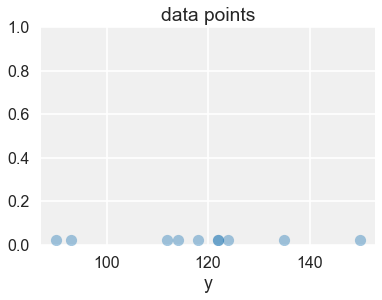

In [115]:
plt.plot(y, np.ones_like(y)/50, 'o', alpha=0.4)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('data points');
plt.gca().set_xlabel('y')

In [116]:
# factorize the joint posterior p(mu,sigma2|y) to p(mu|sigma2,y)p(sigma2|y)
# sample from the joint posterior using this factorization

# sample from p(sigma2|y)
sigma2 = sinvchi2.rvs(n-1, s2, size=1000, random_state=rng)

# sample from p(mu|sigma2,y)
# student-t dist is replaced by standard normal
mu = my + np.sqrt(sigma2/n)*rng.randn(*sigma2.shape)

# display sigma instead of sigma2
sigma = np.sqrt(sigma2)

# sample from the predictive distribution p(ynew|y)
# for each sample of (mu, sigma)
ynew = rng.randn(*mu.shape)*sigma + mu

To understand the sampling of mu. Note that:

$$\mu|\sigma^2,y \sim N(\bar{\mu}, \sigma^2/n)$$ which means

$$\mu = \bar{y} + \frac{\sigma}{\sqrt{n}}X,$$ where $X \sim \cal{N}(0,1)$.

Also remember that the posterior predictive distribution for a future observation $$p(\widetilde{y}|y) = \int p(\widetilde{y}|\mu, \sigma^2,y)p(\mu, \sigma |y)d\mu d\sigma^2 = \int p(\widetilde{y}|\mu, \sigma^2)p(\mu, \sigma |y)d\mu d\sigma^2 $$

The final expression suggests how we sample a new future observation:
1. sample new (\mu,sigma)
2. sample new future y from $N(\mu, \sigma^2)$

Text(0.5,0,'future observation')

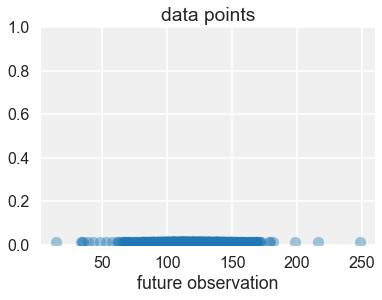

In [117]:
plt.plot(ynew, np.ones_like(ynew)/80, 'o', alpha=0.4)
plt.gca().set_ylim(0, 1)
plt.gca().set_title('data points');
plt.gca().set_xlabel('future observation')

In [118]:
# for mu compute the density in these points
tl1 = [90, 150]
t1 = np.linspace(tl1[0], tl1[1], 1000)
# for sigma compute the density in these points
tl2 = [10, 60]
t2 = np.linspace(tl2[0], tl2[1], 1000)
# for ynew compute the density in these points
tlynew = [50, 185]
xynew = np.linspace(tlynew[0], tlynew[1], 1000)

# evaluate the joint density in a grid
# note that the following is not normalized, but for plotting
# contours it does not matter
# mu|sigma,,y follows N(mean y, sigma^2 /n)
Z = stats.norm.pdf(t1, my, t2[:,np.newaxis]/np.sqrt(n))
# \sigma^2 | y, Inv-chi-square(n-1, s2)
Z *= (sinvchi2.pdf(t2**2, n-1, s2)*2*t2)[:,np.newaxis]

# compute the exact marginal density for mu
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# z=(x-mean(y))/sqrt(s2/n), see BDA3 p. 21
pm_mu = stats.t.pdf((t1 - my) / np.sqrt(s2/n), n-1) / np.sqrt(s2/n)

# estimate the marginal density for mu using samples and an ad hoc Gaussian
# kernel approximation
pk_mu = stats.gaussian_kde(mu).evaluate(t1)

# compute the exact marginal density for sigma
# multiplication by 2*t2 is due to the transformation of variable
# z=t2^2, see BDA3 p. 21
pm_sigma = sinvchi2.pdf(t2**2, n-1, s2)*2*t2
# N.B. this was already calculated in the joint distribution case

# estimate the marginal density for sigma using samples and an ad hoc Gaussian
# kernel approximation
pk_sigma = stats.gaussian_kde(sigma).evaluate(t2)

# compute the exact predictive density
# multiplication by 1./sqrt(s2/n) is due to the transformation of variable
# see BDA3 p. 21
p_new = stats.t.pdf((xynew-my)/np.sqrt(s2*(1+1/n)), n-1) / np.sqrt(s2*(1+1/n))

Joint and marginal posterior distributions


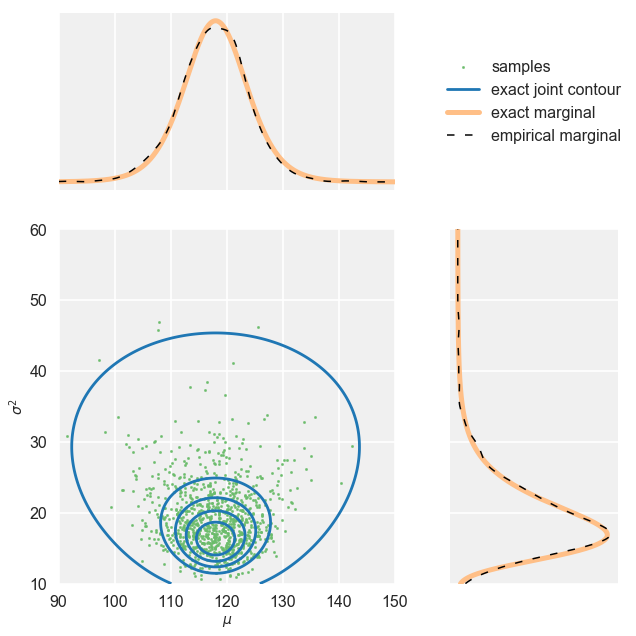

In [119]:
print('Joint and marginal posterior distributions')

# create figure
fig, axes = plt.subplots(
    2, 2,
    figsize=(9, 9),
    gridspec_kw=dict(
        width_ratios=[2, 1],
        height_ratios=[1, 2]
    )
)

# plot the joint distribution
ax = axes[1, 0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize='14')
ax.set_ylabel('$\sigma^2$', fontsize='14')

# plot the marginal of mu
ax = axes[0, 0]
# exact
ax.plot(
    t1,
    pm_mu,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
ax.plot(
    t1,
    pk_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_xlim(tl1)
ax.set_yticks(())
ax.set_xticklabels(())

# plot the marginal of sigma
ax = axes[1, 1]
# exact
exact_line, = ax.plot(
    pm_sigma,
    t2,
    color=plot_tools.lighten('C1'),
    linewidth=5
)
# empirical
empirical_line, = ax.plot(
    pk_sigma,
    t2,
    color='k',
    dashes=(5, 7),
    linewidth=1.5
)
# decorate
ax.set_ylim(tl2)
ax.set_xticks(())
ax.set_yticklabels(())

# hide last ax
ax = axes[0, 1]
ax.axis('off')
# make legend there
ax.legend(
    (
        samps,
        plt.Line2D([], [], color='C0'),
        exact_line,
        empirical_line
    ),
    (
        'samples',
        'exact joint contour',
        'exact marginal',
        'empirical marginal'
    ),
    loc='center',
)

fig.tight_layout()

Visualise factored sampling and the corresponding marginal and conditional densities.

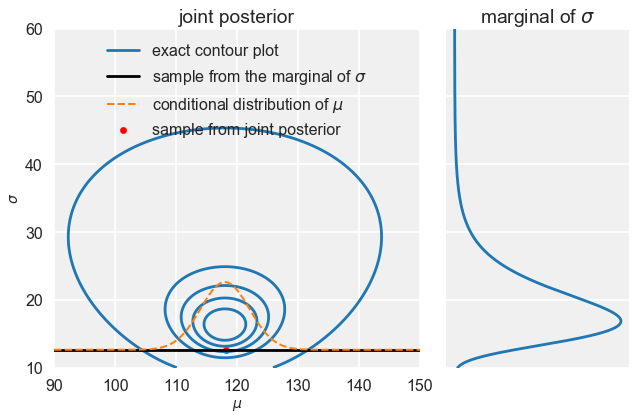

In [120]:
# create figure
fig, axes = plt.subplots(
    1, 2,
    figsize=(9, 6),
    gridspec_kw=dict(width_ratios=[2, 1])
)

# plot the joint distribution
ax = axes[0]
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')

# plot the first sample
line1, = ax.plot(tl1, [sigma[0], sigma[0]], 'k')
line2, = ax.plot(
    t1,
    sigma[0] + stats.norm.pdf(t1, my, np.sqrt(sigma2[0]/n))*100,
    color='C1',
    linestyle='dashed',
    linewidth=2
)
scat = ax.scatter(mu[0], sigma[0], 40, color='r')

# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.set_title('joint posterior')
ax.legend(
    (plt.Line2D([], [], color='C0'), line1, line2, scat),
    ('exact contour plot',
     'sample from the marginal of $\\sigma$',
     'conditional distribution of $\\mu$',
     'sample from joint posterior'),
    loc='upper center'
)

# plot the marginal of sigma
ax = axes[1]
ax.plot(pm_sigma, t2)
# decorate
ax.set_ylim(tl2)
ax.set_title('marginal of $\sigma$')
ax.set_xticks(());
ax.set_yticklabels(())

fig.tight_layout()

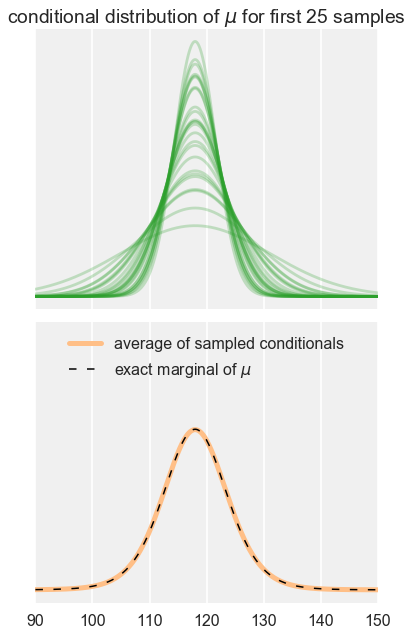

In [121]:
#  calculate conditional pdfs for each sample
condpdfs = stats.norm.pdf(t1, my, np.sqrt(sigma2/n)[:,np.newaxis])

# create figure
fig, axes = plt.subplots(2, 1, figsize=(6, 9), sharex=True)

# plot some of them
ax = axes[0]
ax.plot(t1, condpdfs[:25].T, 'C2', alpha=0.25)
ax.set_xlim(tl1)
ylims_from_0 = ax.set_ylim()  # set same y_lims to the next plot
ax.set_title('conditional distribution of $\\mu$ for first 25 samples')
ax.set_yticks(())

# plot their mean
ax = axes[1]
ax.plot(
    t1,
    np.mean(condpdfs, axis=0),
    color=plot_tools.lighten('C1'),
    linewidth=5,
    label='average of sampled conditionals'
)
ax.plot(
    t1,
    pm_mu,
    color='k',
    dashes=(5, 7),
    linewidth=1.5,
    label='exact marginal of $\\mu$'
)
ax.set_yticks(())
ax.set_xlim(tl1)
ax.set_ylim(ylims_from_0)
ax.legend(loc='upper center')

fig.tight_layout()

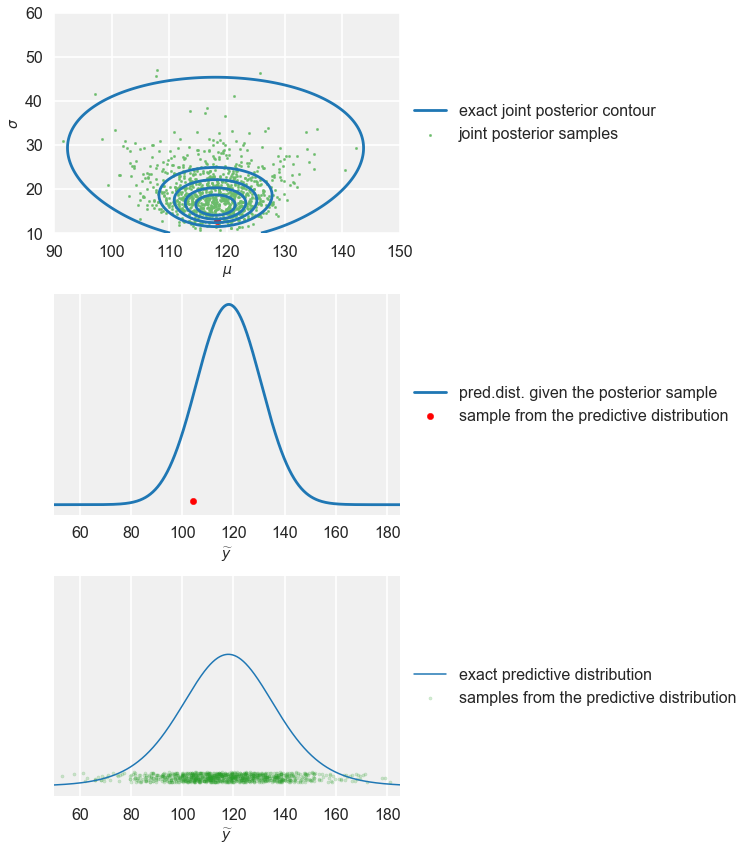

In [122]:
# calculate predictive pdf for the first given mu and sigma sample
ynewdists = stats.norm.pdf(xynew, mu[0], sigma[0])

# create figure
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

# plot the joint distribution
ax = axes[0]
# plot the samples from the joint posterior
samps = ax.scatter(mu, sigma, 5, color=plot_tools.lighten('C2', 0.3))
# plot the contour plot of the exact posterior (c_levels is used to give
# a vector of linearly spaced values at which levels contours are drawn)
c_levels = np.linspace(1e-5, Z.max(), 6)[:-1]
ax.contour(t1, t2, Z, c_levels, colors='C0')
# decorate
ax.set_xlim(tl1)
ax.set_ylim(tl2)
ax.set_xlabel('$\mu$', fontsize=14)
ax.set_ylabel('$\sigma$', fontsize=14)
ax.legend(
    (plt.Line2D([], [], color='C0'), samps),
    ('exact joint posterior contour', 'joint posterior samples'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
# highlight the first sample
ax.scatter(mu[0], sigma[0], 40, 'r')

# plot first ynew
ax = axes[1]
# plot the distribution and the respective sample
line1, = ax.plot(xynew, ynewdists)
ax1_hs = ax.scatter(ynew[0], 0.02*np.max(ynewdists), 40, 'r')
# decorate
ylims_from_1 = ax.set_ylim()
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(
    (line1, ax1_hs),
    ('pred.dist. given the posterior sample',
    'sample from the predictive distribution'),
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)

# plot all ynews
ax = axes[2]
ax.scatter(
    ynew,
    (0.02 + 0.05*rng.rand(*ynew.shape))*np.max(ynewdists),
    10,
    color='C2',
    alpha=0.2,
    label='samples from the predictive distribution'
)
ax.plot(
    xynew,
    p_new,
    linewidth=1.5,
    label='exact predictive distribution'
)
ax.set_ylim(ylims_from_1)
ax.set_xlim(tlynew)
ax.set_xlabel('$\widetilde{y}$', fontsize=14)
ax.set_yticks(())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout()

# Bioassay Example

This example demonstrate how we handle nonconjugate model in the context of a bioassay experiment. Bioassay is the measurement of the potency of a substance using its effect on living tissue.

In [123]:
import numpy as np
from scipy.special import expit  # aka logistic

%matplotlib inline
import matplotlib.pyplot as plt

In [124]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [125]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [126]:
# seed a random state
rng = np.random.RandomState(0)

In [127]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

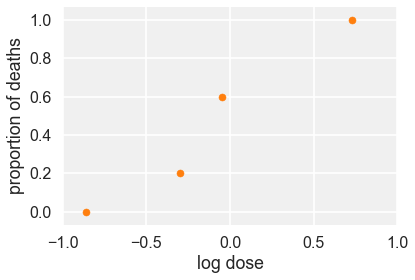

In [128]:
# plot the data
plt.scatter(x, y/n, 50, color='C1')
plt.xlim((-1, 1))
plt.xlabel('log dose')
plt.ylabel('proportion of deaths');

In [129]:
# compute the posterior density in grid
#  - usually should be computed in logarithms!
#  - with alternative prior, check that range and spacing of A and B
#    are sensible
A = np.linspace(-4, 8, 100)
B = np.linspace(-10, 40, 100)
# logistic function
ilogit_abx = 1 / (np.exp(-(A[:,None] + B[:,None,None] * x)) + 1)
# with priority p(a,b) = 1, we have the posterior:
p = np.prod(ilogit_abx**y * (1 - ilogit_abx)**(n - y), axis=2)

The following demonstrates an alternative "bad" way of calcuting the posterior density p in a for loop. The vectorised statement above is numerically more efficient. In this small example however, it would not matter that much.

```python
p = np.empty((len(B),len(A))) # allocate space
for i in range(len(A)):
    for j in range(len(B)):
        ilogit_abx_ij = (1 / (np.exp(-(A[i] + B[j] * x)) + 1))
        p[j,i] = np.prod(ilogit_abx_ij**y * ilogit_abx_ij**(n - y))
```

N.B. the vectorised expression could be made even more efficient, e.g. by optimising memory usage with in-place statements. However, it would result in a less readable code and it is not necessary here.

In [139]:
# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (rng.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (rng.rand(nsamp) - 0.5) * (B[1]-B[0]) n

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]

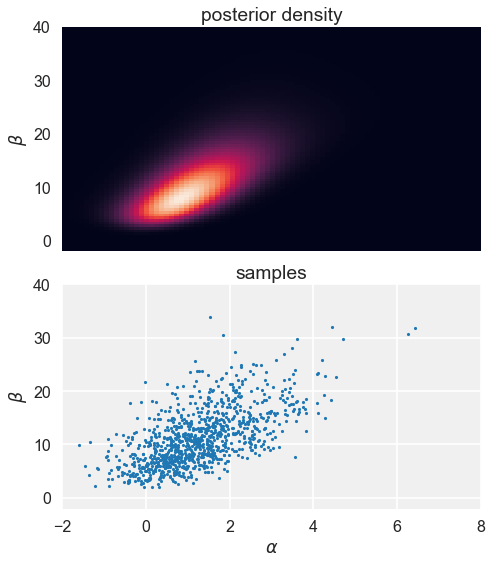

In [140]:
# create figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot the posterior density
ax = axes[0]
ax.imshow(p, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]))
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(samp_A, samp_B, 10, linewidth=0)
ax.set_xlim([-2,8])
ax.set_ylim([-2,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

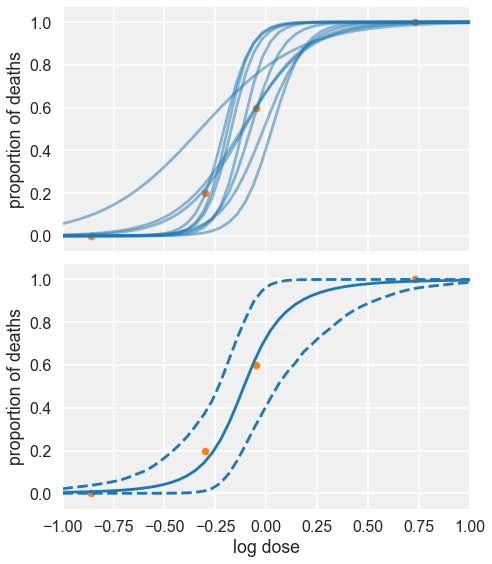

In [137]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# plot mean and [5% 95%] interval
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

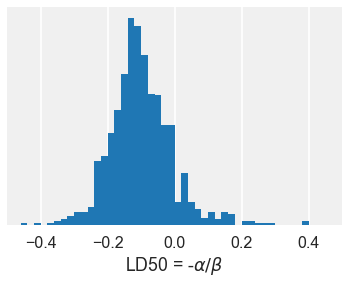

In [138]:
# plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());

In [105]:
x = np.array([[4,5], [1,2]])
x

array([[4, 5],
       [1, 2]])

In [106]:
x.ravel()

array([4, 5, 1, 2])